In [1]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2
# import standard libs
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json
os.environ['THEANO_FLAGS'] = 'device=cpu,floatX=float32'

# import python scientific stack
import pandas as pd
import pandas_datareader.data as web
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math
import pymc3 as pm
from theano import shared, theano as tt

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')

#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
#plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
#plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
import missingno as msno

from src.utils.utils import *
from src.features.bars import get_imbalance
import src.features.bars as brs
import src.features.snippets as snp

RANDOM_STATE = 777

print()
%watermark -p pandas,pandas_datareader,dask,numpy,pymc3,theano,sklearn,statsmodels,scipy,matplotlib,seaborn,pyarrow,fastparquet

2019-03-04T14:25:06+05:00

CPython 3.7.1
IPython 7.2.0

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


/anaconda3/lib/python3.7/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.



pandas 0.23.4
pandas_datareader 0.7.0
dask 1.0.0
numpy 1.15.4
pymc3 3.6
theano 1.0.3
sklearn 0.20.1
statsmodels 0.9.0
scipy 1.1.0
matplotlib 3.0.2
seaborn 0.9.0
pyarrow 0.11.1
fastparquet not installed


In [7]:
def read_kibot_ticks(fp):
    # read tick data from http://www.kibot.com/support.aspx#data_format
    cols = list(map(str.lower,['Date','Time','Price','Bid','Ask','Size']))
    df = (pd.read_csv(fp, header=None)
          .rename(columns=dict(zip(range(len(cols)),cols)))
          .assign(dates=lambda df: (pd.to_datetime(df['date']+df['time'],
                                                  format='%m/%d/%Y%H:%M:%S')))
          .assign(v=lambda df: df['size']) # volume
          .assign(dv=lambda df: df['price']*df['size']) # dollar volume
          .drop(['date','time'],axis=1)
          .set_index('dates')
          .drop_duplicates())
    return df
    
infp = PurePath('data//raw//IVE_tickbidask.txt')

df = read_kibot_ticks(infp)
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask   size      v          dv
dates                                                                
2019-01-11 15:59:58  104.84  104.83  104.85    130    130    13629.20
2019-01-11 16:00:00  104.84  104.83  104.84  11407  11407  1195909.88
2019-01-11 16:10:00  104.84  104.78  105.04      0      0        0.00
2019-01-11 18:30:00  104.84  104.24  105.17      0      0        0.00
2019-01-11 20:00:00  104.84  104.46  105.06      0      0        0.00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1542712 entries, 2009-09-28 09:30:00 to 2019-01-11 20:00:00
Data columns (total 6 columns):
price    1542712 non-null float64
bid      1542712 non-null float64
ask      1542712 non-null float64
size     1542712 non-null int6

In [11]:
outfp = PurePath('data//interim//IVE_tickbidask.parq')
df.to_parquet(outfp)

In [12]:
infp=PurePath('data//interim//IVE_tickbidask.parq')
df = pd.read_parquet(infp)
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask   size      v          dv
dates                                                                
2019-01-11 15:59:58  104.84  104.83  104.85    130    130    13629.20
2019-01-11 16:00:00  104.84  104.83  104.84  11407  11407  1195909.88
2019-01-11 16:10:00  104.84  104.78  105.04      0      0        0.00
2019-01-11 18:30:00  104.84  104.24  105.17      0      0        0.00
2019-01-11 20:00:00  104.84  104.46  105.06      0      0        0.00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1542712 entries, 2009-09-28 09:30:00 to 2019-01-11 20:00:00
Data columns (total 6 columns):
price    1542712 non-null float64
bid      1542712 non-null float64
ask      1542712 non-null float64
size     1542712 non-null int6

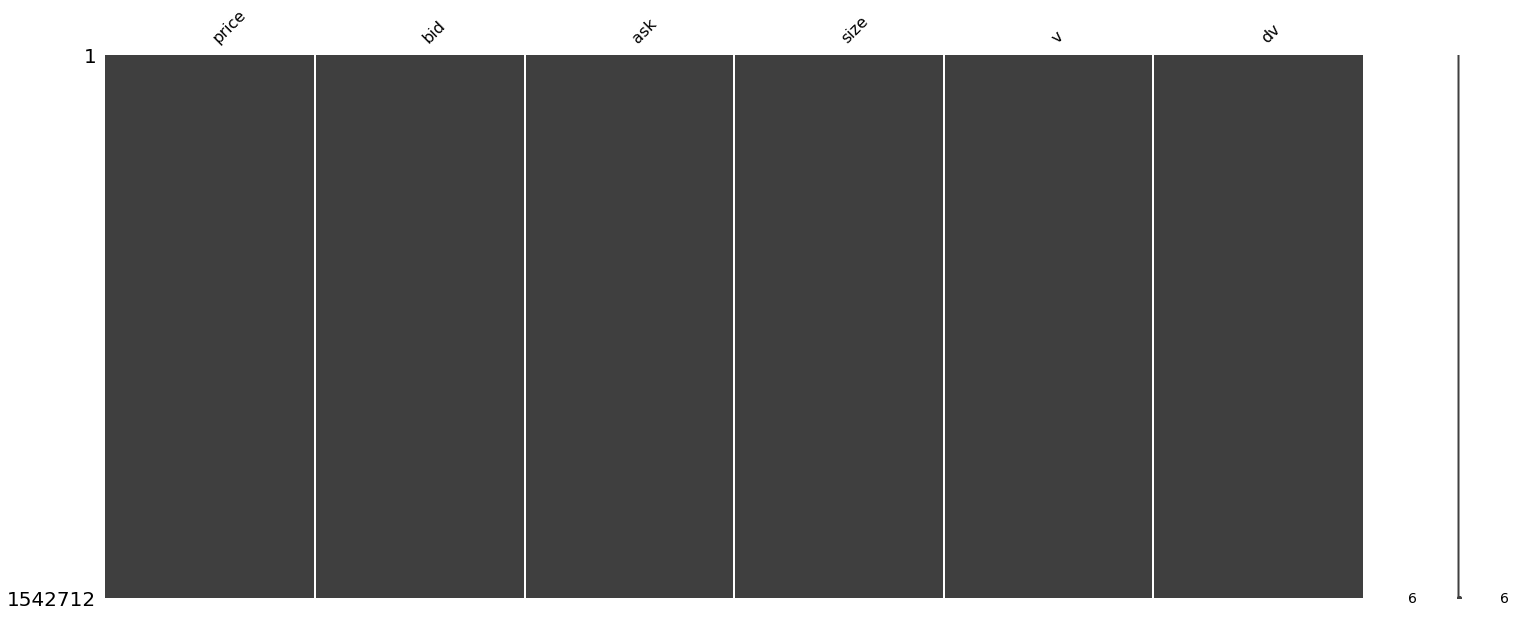

In [13]:
msno.matrix(df)

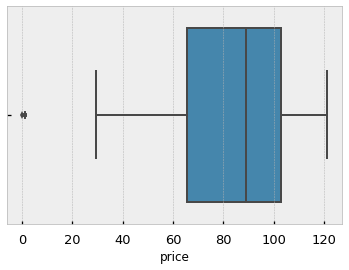

In [14]:
sns.boxplot(df.price)

In [15]:
@jit(nopython=True)
def mad_outlier(y, thresh=3.):
    '''
    compute outliers based on mad
    # args
        y: assumed to be array with shape (N,1)
        thresh: float()
    # returns
        array index of outliers
    '''
    median = np.median(y)
    diff = np.sum((y - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [16]:
mad = mad_outlier(df.price.values.reshape(-1,1))
df.loc[mad]

,price,bid,ask,size,v,dv
dates,,,,,,
2010-05-06 14:49:07,0.11,0.10,44.03,500,500,55.0
2010-05-06 14:53:30,1.10,1.10,30.28,2600,2600,2860.0
2010-05-06 14:55:32,1.10,1.10,50.57,300,300,330.0
2010-05-06 14:55:32,1.10,1.10,50.57,100,100,110.0
2010-05-06 14:55:32,1.10,1.00,50.57,200,200,220.0
2010-05-06 14:55:32,1.10,1.00,50.57,700,700,770.0
2010-05-06 14:55:32,1.10,1.00,50.57,1200,1200,1320.0
2010-05-06 14:55:32,1.10,0.55,50.57,500,500,550.0
2010-05-06 14:55:32,1.10,0.55,50.57,100,100,110.0


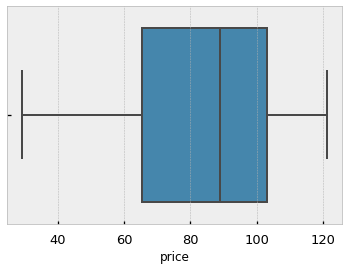

In [17]:
sns.boxplot(df.loc[~mad].price)

In [18]:
df = df.loc[~mad]
cprint(df)

outfp = PurePath('data//processed//clean_IVE_fut_prices.parq')
df.to_parquet(outfp)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask   size      v          dv
dates                                                                
2019-01-11 15:59:58  104.84  104.83  104.85    130    130    13629.20
2019-01-11 16:00:00  104.84  104.83  104.84  11407  11407  1195909.88
2019-01-11 16:10:00  104.84  104.78  105.04      0      0        0.00
2019-01-11 18:30:00  104.84  104.24  105.17      0      0        0.00
2019-01-11 20:00:00  104.84  104.46  105.06      0      0        0.00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1542701 entries, 2009-09-28 09:30:00 to 2019-01-11 20:00:00
Data columns (total 6 columns):
price    1542701 non-null float64
bid      1542701 non-null float64
ask      1542701 non-null float64
size     1542701 non-null int6

In [19]:
infp=PurePath('data//processed//clean_IVE_fut_prices.parq')
df = pd.read_parquet(infp)
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask   size      v          dv
dates                                                                
2019-01-11 15:59:58  104.84  104.83  104.85    130    130    13629.20
2019-01-11 16:00:00  104.84  104.83  104.84  11407  11407  1195909.88
2019-01-11 16:10:00  104.84  104.78  105.04      0      0        0.00
2019-01-11 18:30:00  104.84  104.24  105.17      0      0        0.00
2019-01-11 20:00:00  104.84  104.46  105.06      0      0        0.00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1542701 entries, 2009-09-28 09:30:00 to 2019-01-11 20:00:00
Data columns (total 6 columns):
price    1542701 non-null float64
bid      1542701 non-null float64
ask      1542701 non-null float64
size     1542701 non-null int6

In [26]:
def tick_bars(df, price_column, m):
    t = df[price_column]
    ts = 0
    idx = []
    for i, x in enumerate(t):
        ts += 1
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def tick_bar_df(df, price_column, m):
    idx = tick_bars(df, price_column, m)
    return df.iloc[idx].drop_duplicates()

In [27]:
n_ticks = df.shape[0]
volume_ratio = (df.v.sum()/n_ticks).round()
dollar_ratio = (df.dv.sum()/n_ticks).round()
print(f'num ticks: {n_ticks:,}')
print(f'volume ratio: {volume_ratio}')
print(f'dollar ratio: {dollar_ratio}')

num ticks: 1,542,701
volume ratio: 549.0
dollar ratio: 47556.0


In [28]:
tick_M = 100 # arbitrary
print(f'tick threshold: {tick_M:,}')
tidx = tick_bars(df, 'price', tick_M)
tidx[:10]

tick threshold: 100


[99, 199, 299, 399, 499, 599, 699, 799, 899, 999]

In [29]:
len(tidx), len(df['price'])

(15427, 1542701)

In [30]:
df.iloc[tidx].shape, df.shape

((15427, 6), (1542701, 6))

In [31]:
tick_df = tick_bar_df(df, 'price', tick_M)
tick_df.shape

(15427, 6)

In [38]:
def select_sample_data(ref, sub, price_col, date):
    '''
    select a sample of data based on date, assumes datetimeindex
    
    # args
        ref: pd.DataFrame containing all ticks
        sub: subordinated pd.DataFrame of prices
        price_col: str(), price column
        date: str(), date to select
    # returns
        xdf: ref pd.Series
        xtdf: subordinated pd.Series
    '''
    xdf = ref[price_col].loc[date]
    xtdf = sub[price_col].loc[date]
    return xdf, xtdf

## try different dates to see how the quantity of tick bars changes
xDate ='2017-10-04' #'2017-10-4'
xdf, xtdf = select_sample_data(df, tick_df, 'price', xDate)

xdf.shape, xtdf.shape

((626,), (6,))

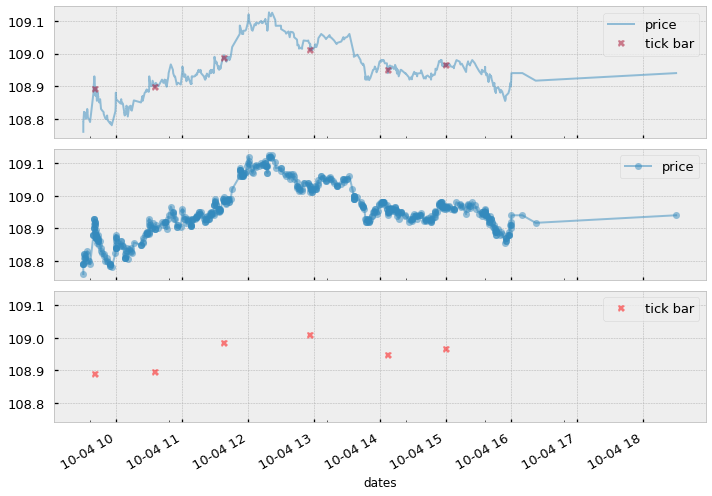

In [39]:
def plot_sample_data(ref, sub, bar_type, *args, **kwds):
    f,axes=plt.subplots(3,sharex=True, sharey=True, figsize=(10,7))
    ref.plot(*args, **kwds, ax=axes[0], label='price')
    sub.plot(*args, **kwds, ax=axes[0], marker='X', ls='', label=bar_type)
    axes[0].legend();
    
    ref.plot(*args, **kwds, ax=axes[1], label='price', marker='o')
    sub.plot(*args, **kwds, ax=axes[2], ls='', marker='X',
             color='r', label=bar_type)

    for ax in axes[1:]: ax.legend()
    plt.tight_layout()
    
    return

plot_sample_data(xdf, xtdf, 'tick bar', alpha=0.5, markersize=7)

In [40]:
def get_ohlc(ref, sub):
    '''
    fn: get ohlc from custom bars
    
    # args
        ref : reference pandas series with all prices
        sub : custom tick pandas series
    # returns
        tick_df : dataframe with ohlc values
    '''
    ohlc = []
    for i in tqdm(range(sub.index.shape[0]-1)):
        start,end = sub.index[i], sub.index[i+1]
        tmp_ref = ref.loc[start:end]
        max_px, min_px = tmp_ref.max(), tmp_ref.min()
        o,h,l,c = sub.iloc[i], max_px, min_px, sub.iloc[i+1]
        ohlc.append((end,start,o,h,l,c))
    cols = ['end','start','open','high','low','close']
    return (pd.DataFrame(ohlc,columns=cols))

In [42]:
sub = tick_df.price
ref = df.price
tick_bars_ohlc = get_ohlc(ref, sub)
cprint(tick_bars_ohlc)

100%|██████████| 15426/15426 [00:05<00:00, 2642.96it/s]

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      end               start      open      high       low  \
15421 2019-01-11 13:45:21 2019-01-11 12:28:46  104.7200  104.9200  104.5502   
15422 2019-01-11 14:32:51 2019-01-11 13:45:21  104.6800  104.8006  104.6483   
15423 2019-01-11 15:25:50 2019-01-11 14:32:51  104.6900  104.7532  104.5845   
15424 2019-01-11 15:41:05 2019-01-11 15:25:50  104.6428  104.8179  104.6267   
15425 2019-01-11 18:30:00 2019-01-11 15:41:05  104.8074  104.8925  104.7643   

          close  
15421  104.6800  
15422  104.6900  
15423  104.6428  
15424  104.8074  
15425  104.8400  
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15426 entries, 0 to 15425
Data columns (total 6 columns):
end      15426 non-null datetime64[ns]
start    15426 non-null datetime64[ns

In [44]:
outfp = PurePath('data//processed//tick_bars_ohlc.parq')
tick_bars_ohlc.to_parquet(outfp)

In [46]:
def volume_bars(df, volume_column, m):
    '''
    compute volume bars

    # args
        df: pd.DataFrame()
        volume_column: name for volume data
        m: int(), threshold value for volume
    # returns
        idx: list of indices
    '''
    t = df[volume_column]
    ts = 0
    idx = []
    for i, x in enumerate(t):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def volume_bar_df(df, volume_column, m):
    idx = volume_bars(df, volume_column, m)
    return df.iloc[idx].drop_duplicates()

volume_M =  10_000 # arbitrary 
print(f'volume threshold: {volume_M:,}')
v_bar_df = volume_bar_df(df, 'v', volume_M)
cprint(v_bar_df)

volume threshold: 10,000
-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                        price     bid     ask   size      v           dv
dates                                                                   
2019-01-11 15:41:19  104.8141  104.81  104.82   2290   2290   240024.289
2019-01-11 15:52:41  104.8500  104.86  104.87    400    400    41940.000
2019-01-11 15:58:14  104.8000  104.79  104.80    294    294    30811.200
2019-01-11 15:59:53  104.8397  104.83  104.85   1300   1300   136291.610
2019-01-11 16:00:00  104.8400  104.83  104.84  11407  11407  1195909.880
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65482 entries, 2009-09-28 09:44:09 to 2019-01-11 16:00:00
Data columns (total 6 columns):
price    65482 non-null float64
bid      65482 non-null float64
ask      65482 non-null 

xdf shape: (1466,), xtdf shape: (48,)


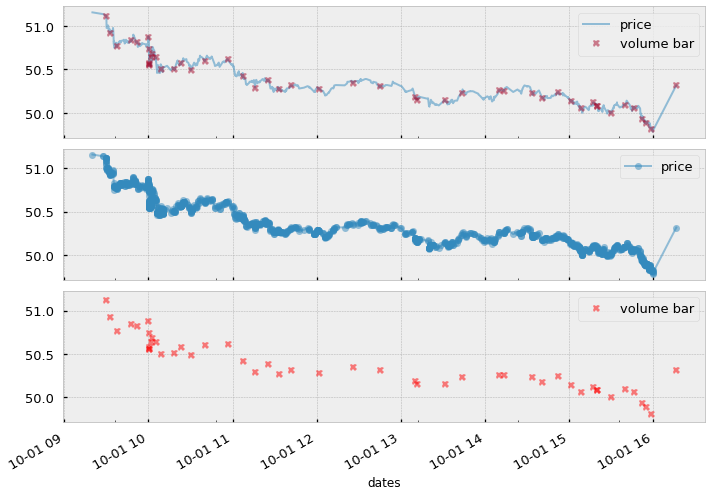

In [47]:
xDate = '2009-10-1'
xdf, xtdf = select_sample_data(df, v_bar_df, 'price', xDate)
print(f'xdf shape: {xdf.shape}, xtdf shape: {xtdf.shape}')

plot_sample_data(xdf, xtdf, 'volume bar', alpha=0.5, markersize=7)  

In [49]:
def dollar_bars(df, dv_column, m):
    '''
    compute dollar bars

    # args
        df: pd.DataFrame()
        dv_column: name for dollar volume data
        m: int(), threshold value for dollars
    # returns
        idx: list of indices
    '''
    t = df[dv_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def dollar_bar_df(df, dv_column, m):
    idx = dollar_bars(df, dv_column, m)
    return df.iloc[idx].drop_duplicates()

dollar_M = 1_000_000 # arbitrary 
print(f'dollar threshold: {dollar_M:,}')
dv_bar_df = dollar_bar_df(df, 'dv', dollar_M)
cprint(dv_bar_df)

  4%|▍         | 60663/1542701 [00:00<00:02, 606623.35it/s]

dollar threshold: 1,000,000


100%|██████████| 1542701/1542701 [00:00<00:00, 2006854.03it/s]


-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                        price     bid     ask   size      v            dv
dates                                                                    
2019-01-11 15:41:10  104.8115  104.81  104.82    760    760  7.965674e+04
2019-01-11 15:46:51  104.8700  104.85  104.86    200    200  2.097400e+04
2019-01-11 15:55:29  104.8200  104.81  104.83    200    200  2.096400e+04
2019-01-11 15:58:33  104.7777  104.77  104.78    735    735  7.701161e+04
2019-01-11 16:00:00  104.8400  104.83  104.84  11407  11407  1.195910e+06
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56257 entries, 2009-09-28 09:46:35 to 2019-01-11 16:00:00
Data columns (total 6 columns):
price    56257 non-null float64
bid      56257 non-null float64
ask      56257 non-null float64
size     5

xdf shape: (1466,), xtdf shape: (26,)


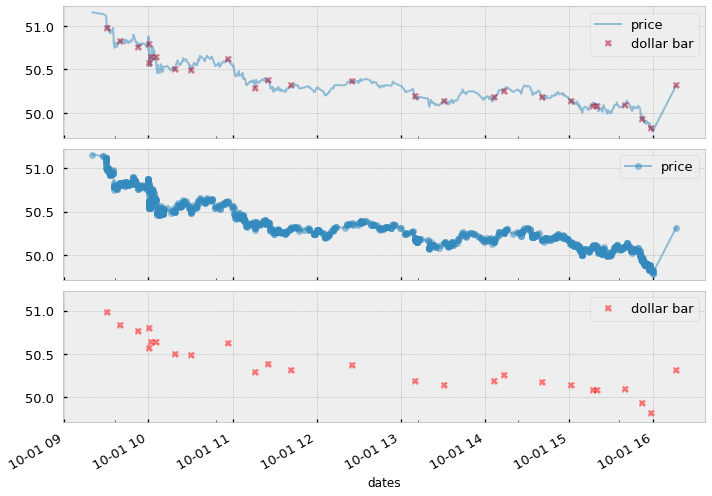

In [50]:
xDate = '2009-10-1'
xdf, xtdf = select_sample_data(df, dv_bar_df, 'price', xDate)
print(f'xdf shape: {xdf.shape}, xtdf shape: {xtdf.shape}')

plot_sample_data(xdf, xtdf, 'dollar bar', alpha=0.5, markersize=7)

In [51]:
#########Bar analyzing

def count_bars(df, price_col='price'):
    return df.groupby(pd.TimeGrouper('1W'))[price_col].count()

def scale(s):
    return (s-s.min())/(s.max()-s.min())

tc = scale(count_bars(tick_df))
vc = scale(count_bars(v_bar_df))
dc = scale(count_bars(dv_bar_df))
dfc = scale(count_bars(df))

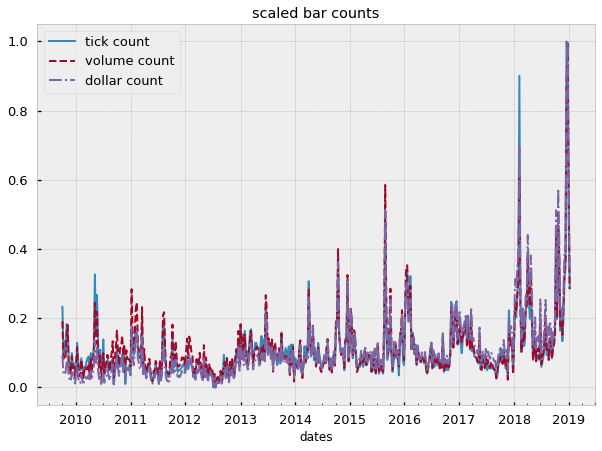

In [52]:
f,ax=plt.subplots(figsize=(10,7))

tc.plot(ax=ax, ls='-', label='tick count')
vc.plot(ax=ax, ls='--', label='volume count')
dc.plot(ax=ax, ls='-.', label='dollar count')

ax.set_title('scaled bar counts')
ax.legend()

In [53]:
#bar counts stablization 


print(f'tc std: {tc.std():.2%}, vc std: {vc.std():.2%}, dc std: {dc.std():.2%}')

bar_types = ['tick','volume','dollar','df']
bar_std = [tc.std(),vc.std(),dc.std(),dfc.std()]
counts = (pd.Series(bar_std,index=bar_types))
counts.sort_values()

tc std: 9.78%, vc std: 9.56%, dc std: 10.37%


volume    0.095564
tick      0.097836
df        0.098504
dollar    0.103691
dtype: float64

In [54]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

tr = returns(tick_df.price)
vr = returns(v_bar_df.price)
dr = returns(dv_bar_df.price)
df_ret = returns(df.price)   

bar_returns = [tr, vr, dr, df_ret]

In [55]:
def get_test_stats(bar_types,bar_returns,test_func,*args,**kwds):
    
    dct = {bar:(int(bar_ret.shape[0]), test_func(bar_ret,*args,**kwds)) 
           for bar,bar_ret in zip(bar_types,bar_returns)}
    df = (pd.DataFrame.from_dict(dct)
          .rename(index={0:'sample_size',1:f'{test_func.__name__}_stat'})
          .T)
    return df

autocorrs = get_test_stats(bar_types,bar_returns,pd.Series.autocorr)
display(autocorrs.sort_values('autocorr_stat'),
        autocorrs.abs().sort_values('autocorr_stat'))

,sample_size,autocorr_stat
dollar,56256.0,-0.119705
df,1542700.0,-0.092308
volume,65481.0,-0.017257
tick,15426.0,0.057977


,sample_size,autocorr_stat
volume,65481.0,0.017257
tick,15426.0,0.057977
df,1542700.0,0.092308
dollar,56256.0,0.119705


In [57]:
def plot_autocorr(bar_types,bar_returns):
    f,axes=plt.subplots(len(bar_types),figsize=(10,7))

    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        sm.graphics.tsa.plot_acf(bar, lags=120, ax=axes[i],
                                 alpha=0.05, unbiased=True, fft=True,
                                 zero=False,
                                 title=f'{typ} AutoCorr')
    plt.tight_layout()   
    
def plot_hist(bar_types,bar_rets):
    f,axes=plt.subplots(len(bar_types),figsize=(10,6))
    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        g = sns.distplot(bar, ax=axes[i], kde=False, label=typ)
        g.set(yscale='log')
        axes[i].legend()
    plt.tight_layout()    

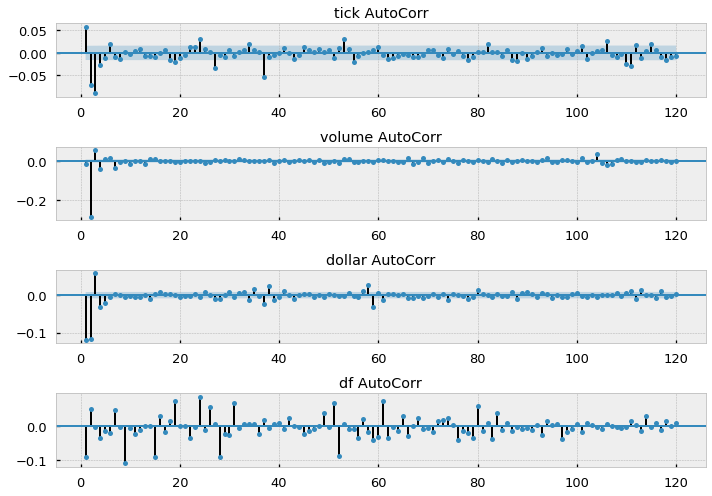

In [58]:
 plot_autocorr(bar_types,bar_returns)

In [59]:
def partition_monthly(s):
    return s.resample('1M').var()

In [60]:
tr_rs = partition_monthly(tr)
vr_rs = partition_monthly(vr)
dr_rs = partition_monthly(dr)
df_ret_rs = partition_monthly(df_ret)
monthly_vars = [tr_rs, vr_rs, dr_rs, df_ret_rs]

get_test_stats(bar_types,monthly_vars,np.var).sort_values('var_stat')

,sample_size,var_stat
df,113.0,5.157338e-12
tick,113.0,1.849290e-09
dollar,113.0,2.044743e-09
volume,113.0,2.639129e-09


In [61]:
## Jarque-Bera Test


def jb(x,test=True): 
    np.random.seed(12345678)
    if test: return stats.jarque_bera(x)[0]
    return stats.jarque_bera(x)[1]

get_test_stats(bar_types,bar_returns,jb).sort_values('jb_stat')

,sample_size,jb_stat
tick,15426.0,1.446872e+08
dollar,56256.0,6.613912e+10
volume,65481.0,3.924374e+11
df,1542700.0,2.510636e+14


In [ ]:
#JB test results means errors are not normally distributed, large J-B value indicates that errors are not normally distributed.

In [62]:
def shapiro(x,test=True): 
    np.random.seed(12345678)
    if test: return stats.shapiro(x)[0]
    return stats.shapiro(x)[1]

(get_test_stats(bar_types,bar_returns,shapiro)
 .sort_values('shapiro_stat')[::-1])  #small values indicate sample is not normally distributed## 

,sample_size,shapiro_stat
tick,15426.0,0.666882
dollar,56256.0,0.417819
volume,65481.0,0.292945
df,1542700.0,0.184162


In [ ]:
#####Compare Serial Correlation between Dollar and Dollar Imbalance Bars

In [63]:
tidx = get_imbalance(df.price.values)*df.dv.iloc[1:]
cprint(tidx)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                             dv
dates                          
2019-01-11 15:59:58    13629.20
2019-01-11 16:00:00  1195909.88
2019-01-11 16:10:00        0.00
2019-01-11 18:30:00        0.00
2019-01-11 20:00:00        0.00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1542700 entries, 2009-09-28 09:30:00 to 2019-01-11 20:00:00
Data columns (total 1 columns):
dv    1542700 non-null float64
dtypes: float64(1)
memory usage: 23.5 MB
None
-------------------------------------------------------------------------------



In [64]:
wndo = tidx.shape[0]//1000
print(f'window size: {wndo:,.2f}')

## Expected value of bs approximated by ewm
E_bs = tidx.ewm(wndo).mean() # expected `bs`

## what is E_T??? 
## in this implementation E_T is ewm of index values
E_T = pd.Series(range(tidx.shape[0]), index=tidx.index).ewm(wndo).mean()

df0 =(pd.DataFrame().assign(bs=tidx)
      .assign(E_T=E_T).assign(E_bs=E_bs)
      .assign(absMul=lambda df: df.E_T*np.abs(df.E_bs))
      .assign(absTheta=tidx.cumsum().abs()))
cprint(df0)

window size: 1,542.00
-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                             bs        E_T          E_bs        absMul  \
dates                                                                    
2019-01-11 15:59:58    13629.20  1541153.0 -77738.997231  1.198077e+11   
2019-01-11 16:00:00  1195909.88  1541154.0 -76913.560499  1.185356e+11   
2019-01-11 16:10:00        0.00  1541155.0 -76863.713733  1.184589e+11   
2019-01-11 18:30:00        0.00  1541156.0 -76813.899272  1.183822e+11   
2019-01-11 20:00:00        0.00  1541157.0 -76764.117095  1.183056e+11   

                         absTheta  
dates                              
2019-01-11 15:59:58  1.719557e+09  
2019-01-11 16:00:00  1.718361e+09  
2019-01-11 16:10:00  1.718361e+09  
2019-01-11 18:30:00  1.718361e+09  
2019-01-11 20:00:00  1.718361e+09  
-------------------------

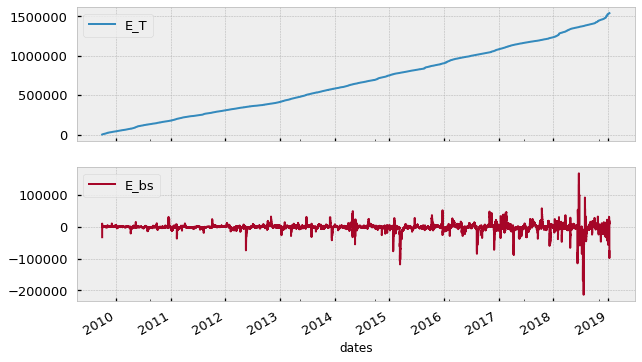

In [65]:
df0[['E_T','E_bs']].plot(subplots=True, figsize=(10,6));

In [66]:
display(df0.describe()/1000)

,bs,E_T,E_bs,absMul,absTheta
count,1542.700000,1542.700000,1542.700000,1.542700e+03,1.542700e+03
mean,-1.113866,769.810036,-1.033634,5.750377e+06,4.088272e+05
std,673.586837,445.334896,12.354621,1.364619e+07,4.167382e+05
min,-244194.944400,0.000000,-213.689110,0.000000e+00,3.537070e-01
25%,-19.970000,384.132750,-2.964695,4.977620e+05,5.126449e+04
50%,-5.030000,769.807500,-0.147955,1.809209e+06,2.221183e+05
75%,19.817029,1155.482250,2.628370,5.458791e+06,6.298905e+05
max,289491.800000,1541.157000,168.792104,2.942781e+08,1.721288e+06


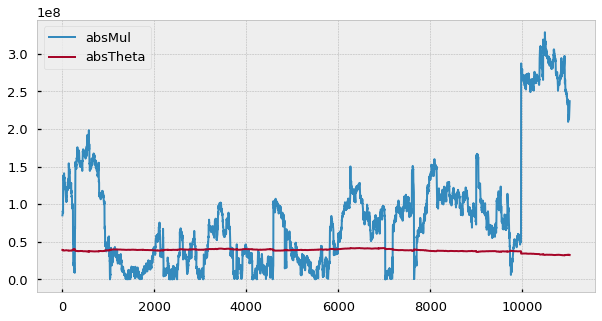

In [67]:
(df0.loc['2010-06',['absMul','absTheta']]
 .reset_index(drop=True)
 .plot(figsize=(10,5)))

In [68]:
def test_t_abs(absTheta,t,E_bs):
    """
    Bool function to test inequality
    *row is assumed to come from df.itertuples()
    -absTheta: float(), row.absTheta
    -t: pd.Timestamp()
    -E_bs: float(), row.E_bs
    """
    return (absTheta >= t*E_bs)

def agg_imbalance_bars(df):
    """
    Implements the accumulation logic
    """
    start = df.index[0]  
    bars = []
    for row in df.itertuples():
        t_abs = row.absTheta
        rowIdx = row.Index
        E_bs = row.E_bs
        
        t = df.loc[start:rowIdx].shape[0]
        if t<1: t=1 # if t lt 1 set equal to 1
        if test_t_abs(t_abs,t,E_bs):
            bars.append((start,rowIdx,t))
            start = rowIdx
    return bars

In [69]:
bars = agg_imbalance_bars(df0)
test_imb_bars = (pd.DataFrame(bars,columns=['start','stop','Ts'])
                 .drop_duplicates())
cprint(test_imb_bars)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      start                stop  Ts
1542671 2019-01-11 15:59:53 2019-01-11 15:59:58   4
1542672 2019-01-11 15:59:58 2019-01-11 16:00:00   2
1542673 2019-01-11 16:00:00 2019-01-11 16:10:00   2
1542674 2019-01-11 16:10:00 2019-01-11 18:30:00   2
1542675 2019-01-11 18:30:00 2019-01-11 20:00:00   2
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300183 entries, 0 to 1542675
Data columns (total 3 columns):
start    1300183 non-null datetime64[ns]
stop     1300183 non-null datetime64[ns]
Ts       1300183 non-null int64
dtypes: datetime64[ns](2), int64(1)
memory usage: 39.7 MB
None
-------------------------------------------------------------------------------



In [70]:
 test_imb_bars.Ts.describe().round()

count    1300183.0
mean           3.0
std            2.0
min            1.0
25%            2.0
50%            2.0
75%            3.0
max          139.0
Name: Ts, dtype: float64

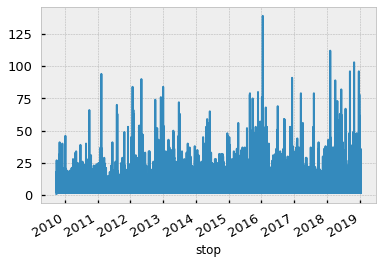

In [71]:
test_imb_bars.set_index('stop')['Ts'].plot()

In [72]:
dvImbBars = df.price.loc[test_imb_bars.stop].drop_duplicates()
cprint(dvImbBars)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                        price
dates                        
2019-01-11 15:58:33  104.7779
2019-01-11 15:58:33  104.7715
2019-01-11 15:58:46  104.7918
2019-01-11 15:59:01  104.8126
2019-01-11 15:59:53  104.8396
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 280032 entries, 2009-09-28 09:30:00 to 2019-01-11 15:59:53
Data columns (total 1 columns):
price    280032 non-null float64
dtypes: float64(1)
memory usage: 4.3 MB
None
-------------------------------------------------------------------------------



In [73]:
dvBar = dv_bar_df.price
cprint(dvBar)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                        price
dates                        
2019-01-11 15:41:10  104.8115
2019-01-11 15:46:51  104.8700
2019-01-11 15:55:29  104.8200
2019-01-11 15:58:33  104.7777
2019-01-11 16:00:00  104.8400
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56257 entries, 2009-09-28 09:46:35 to 2019-01-11 16:00:00
Data columns (total 1 columns):
price    56257 non-null float64
dtypes: float64(1)
memory usage: 3.4 MB
None
-------------------------------------------------------------------------------



In [74]:
dr = returns(dv_bar_df.price)
drImb = returns(dvImbBars)

In [75]:
bar_types = ['dvBar','dvImb']
bar_rets = [dr, drImb]

get_test_stats(bar_types,bar_rets,pd.Series.autocorr)

,sample_size,autocorr_stat
dvBar,56256.0,-0.119705
dvImb,280031.0,-0.073334


In [76]:
jbs = get_test_stats(bar_types,bar_returns,jb).sort_values('jb_stat')
shaps = (get_test_stats(bar_types,bar_returns,shapiro)
         .sort_values('shapiro_stat')[::-1])

display(jbs,shaps)

,sample_size,jb_stat
dvBar,15426.0,1.446872e+08
dvImb,65481.0,3.924374e+11


,sample_size,shapiro_stat
dvBar,15426.0,0.666882
dvImb,65481.0,0.292945
